[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ccc-frankfurt/aisel-hands-on/blob/main/notebooks/PedestrianDetector-BackgroundModel.ipynb)

# AISEL -- Pedestrian Detector 
based on the PHD Thesis of Michael Greiffenhagen: "Engineering, Statistical Modeling and Performance Characterization of a Real-Time Dual Camera Surveillance System" Erlangen 2001
## Module 2: Background model in stationary environment and color based change detection</p>

In [1]:
import os
import cv2
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.spatial import distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
%matplotlib notebook

In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

Load pedestrian video file from epfl from https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/.

## Part 1: A robust measure for background modeling

In [2]:
!wget https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/thraki/.wget-hsts'. HSTS will be disabled.
--2020-10-16 11:18:58--  https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi [following]
--2020-10-16 11:18:59--  https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi [following]
--2020-10-16 11:18:59--  https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi


In [3]:
file ='./epflpedestshort.avi?raw=true'
cap = cv2.VideoCapture(file)

In Module 1 we introduced the illumination invariant normalised color channels r and g. We will use them as input to the background modelling.

In [4]:
def get_normalised_channels(img, pix=None):
    """Extract BGR channel of an image and return normalised r and g channels."""
    if pix:
        b,g,r = img[pix[0]][pix[1]]
    else:
        b,g,r = cv2.split(img)
    # Intensities are stored as int8, upcast for mathematical operations
    b = b.astype('int16');g = g.astype('int16');r = r.astype('int16')
    # Calculate sum over all channels
    rgb = np.add(r,np.add(b,g))
    # Calculate normalised channels
    r_norm = np.divide(r,rgb)
    g_norm = np.divide(g,rgb)
    return r_norm, g_norm

How can the background in the scene be modelled? What are the stable features in r and g?  How can we assign for each pixel the probability of it being background or not?

Let us have a look at one pixel in the pedestrian video. Please try and see what happens for other pixels.
What does this mean for a potential calibration of the system?

In [5]:
i=34;j=53 # set pixel you want to inspect in the demo

In [6]:
fig,ax = plt.subplots(1,3,figsize=(10, 5))

# Re-load the video
cap = cv2.VideoCapture(file)

# containers to track the evolution of r,g
r_norm_pixel = []
g_norm_pixel = []

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    
    # display original frame 
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax[0].imshow(frame_rgb)    
    
    # display pixel under investigation
    ax[1].set_title("Pixel "+str(i)+','+str(j) +" Int.(R,G,B)")
    ax[1].imshow([frame[i][j]],cmap="gray",vmin=0, vmax=255)
          
    # get normalised channels at one pixel
    #r_norm, g_norm  = get_normalised_channels(frame)  
    r_norm, g_norm  = get_normalised_channels(frame,(i,j))
    
    # add to list on the fly
    r_norm_pixel.append(r_norm)
    g_norm_pixel.append(g_norm)   
    
    # and plot 
    col_normed=['red','green']
    for k,col_norm in enumerate([r_norm_pixel,g_norm_pixel]):
        ax[2].hist(col_norm,alpha=0.5,bins=20,color=col_normed[k],range=[0.2,0.4])
    
    #####################################
    # directives for plotting and layout -- not so interesting to you
    # todo: hide
    
    ax[0].set_title("Original video stream")
    ax[1].set_title("Pixel "+str(i)+','+str(j) +" Int.(R,G,B)")
    ax[2].set_title('Hist. Pix '+str(i)+','+str(j))
    ax[2].set_xlabel('Norm. Intensity r,g',fontsize=14)
    ax[2].set_ylabel('Frequency ',fontsize=14)
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in col_normed]
    ax[2].legend(handles, col_normed)
    
    plt.tight_layout()   
    fig.canvas.draw()
   
    ax[0].clear();ax[1].clear();ax[2].clear()
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

Questions: Can you guess what the stable features in r,g are with respect to the background?

Let $\mu$ be the vector of the means of r and g: $\mu= \begin{pmatrix} r & g  \end{pmatrix}$. Assume $\mu$  follows a normal distribution. 

$\hat{}$  are indicating estimates of the true (unknown) parameters, e.g. $\hat{\mu}$ is an estimate for $\mu$

Questions: What does the last sentence mean or what is a true parameter? Let $\mu_b$ = $\mu$ be a candidate for our background model . What properties must it have, how can we differentiate between background and not background? What would this mean for calibration of the system and system evolution over time? When would the background esimation method break/not work at all?

Now let us get $\mu$ and the covariance matrix of r,g for all pixels in the video over certain  a certain period of time.

Run over the first part of the video to get and collect the normed channel value

In [11]:
# containers to track evolution of mean
r_norm_vid = []; g_norm_vid = []

# limit frames to the first appearing in the video
i_frame=0
cap = cv2.VideoCapture(file)
success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    # our main call to get normalised channels
    r_norm, g_norm  = get_normalised_channels(frame)
    
    r_norm_vid.append(r_norm)
    g_norm_vid.append(g_norm)
    
    i_frame=i_frame+1
    if i_frame>1000: # limit frames to the first appearing in the video
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

Inspect the r,g distribution for one pixel anc calculate the mean for the distribution:

In [12]:
#set pixel
i=34;j=53

In [13]:
r_norm_pix = [arr[i][j] for arr in r_norm_vid]
g_norm_pix = [arr[i][j] for arr in g_norm_vid]

In [14]:
r_norm_mean = np.nanmean(r_norm_pix)
g_norm_mean = np.nanmean(g_norm_pix)

<IPython.core.display.Javascript object>


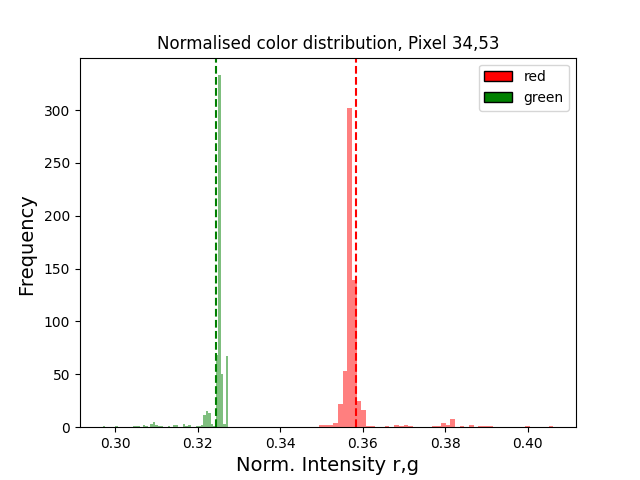

In [15]:
# plot the distribution, the vertical lines indicate the mean
fig,ax = plt.subplots(1)
ax.hist(r_norm_pix,bins = 50, color="red", alpha=0.5)#,range=[0.3,0.4])
ax.axvline(x=r_norm_mean, color = "red", linestyle = '--')
ax.hist(g_norm_pix,bins = 50,color="green",alpha=0.5)#,range=[0.3,0.4])
ax.axvline(x=g_norm_mean, color = "green", linestyle = '--')
ax.set_title('Normalised color distribution, Pixel '+ str(i) + ',' + str(j))
ax.set_xlabel('Norm. Intensity r,g', fontsize=14)
ax.set_ylabel('Frequency ', fontsize=14)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in col_normed]
ax.legend(handles, col_normed)
fig.canvas.draw()


Now build our candidate for the background mean estimate $\mu_b$

In [16]:
mu_b = np.stack((np.nanmean(r_norm_vid,axis=0),np.nanmean(g_norm_vid,axis=0)),axis=2)

In [17]:
# check its shape
mu_b.shape

(50, 100, 2)

# Part 2: The squared malahanobis distance measure as test statistic for the background  hypothesis

Let us define a test statistic for a current pixel being background. A test statistic is a measure on which hypothesis tests can be carried out. Finding the optimal test statistic for your hypothesis test is challenging.


Questions: What is our hypothesis, that we want to verify or falsify? How can this mathematically be expressed?

Let $H_0$ be the hypothesis that a pixel belongs to background, do we need an alternate Hypothesis $H_1$ ?


The squared Mahalanobis distance is defined as $\hat(d)^2 = \begin{pmatrix} \hat{\mu}_b & \hat{\mu}_c  \end{pmatrix}^T (cov(r_c,g_c)+cov(r_b,g_b))^{-1} \begin{pmatrix} \hat{\mu}_b & \hat{\mu}_c  \end{pmatrix}  $  with $\mu_c$ being the normalized color channel vector of the current pixel $\mu_c=\begin{pmatrix} \hat{r}_c & \hat{g}_c  \end{pmatrix} $ and cov() the covariance matrix.

The covariance matrix of r,g per pixel can be calculated as follows

In [20]:
def get_cov(r_norm_vid, g_norm_vid):
    """Input wo matrices containing tuples, calulate elementwise the covariance and return the inverse of covariance matrices."""
    # Not vectorised for demo reasons, in production-> vectorise all numpy operations
    x,y = r_norm_vid[0].shape
    result = []
    last_inv_cov = None
    for i in range(x):
        for j in range(y):
            r_norm_pix = [r[i,j] for r in r_norm_vid]
            g_norm_pix = [g[i,j] for g in g_norm_vid]
            cov = np.cov(r_norm_pix,g_norm_pix)
            #cov = np.cov(r_norm_pix[~np.isnan(r_norm_pix)],g_norm_pix[~np.isnan(g_norm_pix)])
            ## hack to deal with non invertible cov matrices, replace with noise
            try:
                inv_cov =  np.linalg.inv(cov)
                last_inv_cov = inv_cov
            except:
                print("picked last cov mat @",i,j)
                inv_cov = last_inv_cov                          
            result.append(inv_cov)
    result = np.array(result)
    return result,(x,y)

Calculate the cov matrices

In [21]:
inv_cov_mat, cov_shape = get_cov(r_norm_vid, g_norm_vid)

In [22]:
cov_mat_2d = np.reshape(inv_cov_mat, (cov_shape[0], cov_shape[1],2,2) )

Function to calculate the squared mahalanobis distance:

In [23]:
def get_mahaldist(mu_b_arr,mu_c_arr,inv_cov_arr):
    "Returns mahalanobis distance measure for matrices of tuples and one matrix of 2X2 inverse covariance matrices"
    ## Not vectories for demo reasons: In production-> vectorise all numpy operations
    x,y,z = mu_c.shape   
    result = []
    for i in range(x):
        for j in range(y):         
            d2 = distance.mahalanobis(mu_b_arr[i][j],mu_c_arr[i][j],inv_cov_arr[i][j])
            result.append(d2)
    return np.reshape(result,(x,y))


In [24]:
## Loop over the video and save for constant mu_b and constant covariance matrix 

cap = cv2.VideoCapture(file)

d2_container = {}
mu_c_r_container = {}

i_frame = 0

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    if i_frame > 500:
        break
   
    r_norm, g_norm  = get_normalised_channels(frame)    
    
    mu_c = (r_norm, g_norm)
    mu_c = np.stack((r_norm,g_norm),axis=2)
    mu_c_r_container[i_frame] = mu_c
    
    d2 = get_mahaldist(mu_b,mu_c, cov_mat_2d)
    d2_container[i_frame] = d2
    
    i_frame = i_frame+1
    
    
cap.release()
cv2.destroyAllWindows()

Let us plot the mahalanobis distance for one pixel 

In [25]:
# set pixel
i=34;j=53 

In [26]:
d2_pix_frame = {(frame_n,arr[i][j]) for (frame_n, arr) in d2_container.items()}

In [27]:
d2_pix = [x[1] for x in d2_pix_frame]

<IPython.core.display.Javascript object>


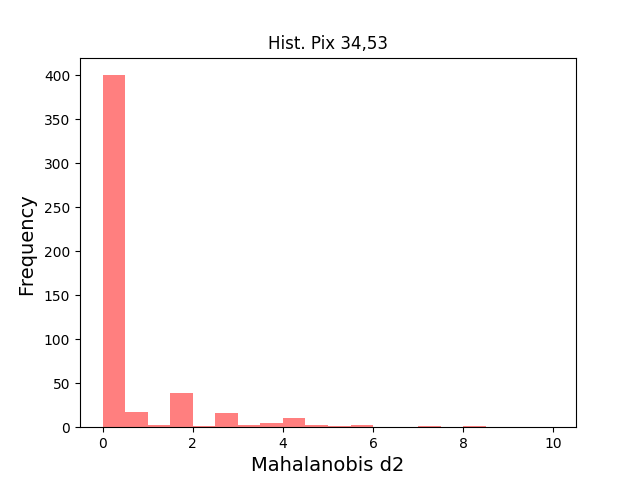

In [28]:
# plot the mahalanobis distance, can you guess the distribution it follows
fig,ax = plt.subplots(1)
ax.hist(d2_pix,bins = 20, color="red", alpha=0.5,range=[0,10])
ax.set_title('Hist. Pix '+str(i)+','+str(j))
ax.set_xlabel('Mahalanobis d2', fontsize=14)
ax.set_ylabel('Frequency ', fontsize=14)
#ax.set_yscale('log')
fig.canvas.draw()

Bringin it all together  in the video and re-calculate $mu_b$ on the fly in every iteration

<IPython.core.display.Javascript object>


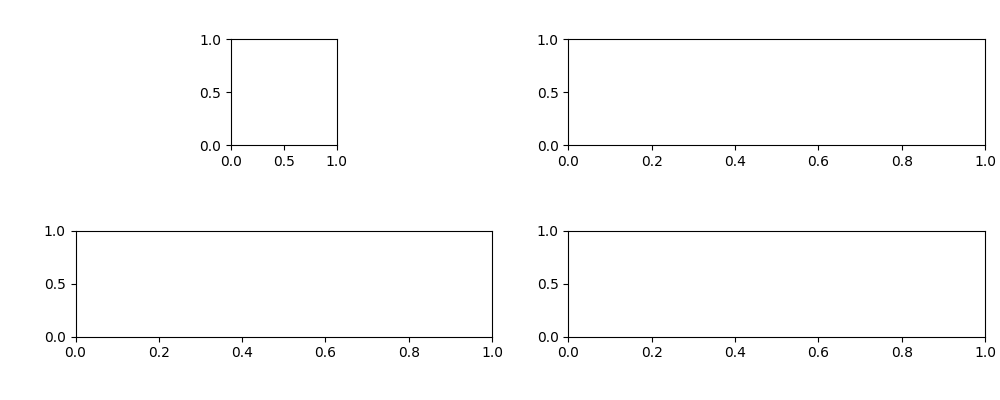

/home/thraki/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Degrees of freedom <= 0 for slice


In [34]:
fig,ax = plt.subplots(2,2,figsize=(10, 4))

cap = cv2.VideoCapture(file)
# containers to track evolution
r_norm_pixel = []
g_norm_pixel = []

#containers to calculate distrance measure for background hypothesis test
d2 = []
cont_mean_r_b = []
cont_mean_g_b = []

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
      
    ax[0][0].set_title("Orig. video")
    ax[0][0].imshow(frame)
      
    ## Transfromation 1
    r_norm, g_norm  = get_normalised_channels(frame)    
    ax[1][0].set_title('Hist. Pix '+str(i)+','+str(j))
    ax[1][0].set_xlabel('Norm. Intensity r,g',fontsize=14)
    ax[1][0].set_ylabel('Frequency ',fontsize=14)
    
    col_normed=['red','green']
    r_norm_pixel.append(r_norm[i][j])
    g_norm_pixel.append(g_norm[i][j])
    
    for k,col_norm_pix in enumerate([r_norm_pixel,g_norm_pixel]):
        ax[1][0].hist(col_norm_pix,alpha=0.7,bins=20,color=col_normed[k],range=(0.2,0.4))
    
    ### Get distance measure for background hypothesis test, re-calculate at every iteration
    mean_r_b = np.mean(r_norm_pixel)
    mean_g_b = np.mean(g_norm_pixel)
    
    cont_mean_r_b.append(mean_r_b)
    cont_mean_g_b.append(mean_g_b)
   
    for k,col_mean_b in enumerate([cont_mean_r_b,cont_mean_g_b]):
        ax[0][1].plot(col_mean_b,alpha=0.7,color=col_normed[k])
        
    ax[0][1].set_title('$\mu_b$ Pix.'+str(i)+','+str(j))
    ax[0][1].set_xlabel('Nr. of frame',fontsize=14)
    ax[0][1].set_ylabel('$\hat{r}_b, , \hat{g}_b$',fontsize=14) 
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in col_normed]
    ax[0][1].legend(handles, col_normed)

    mu_b_s = (mean_r_b,mean_g_b)
    cov = np.cov(r_norm_pixel,g_norm_pixel)
    mu_c_s =(r_norm[i][j],g_norm[i][j])
    try:
        inv_cov =  np.linalg.inv(cov)
        d2.append(distance.mahalanobis(mu_b_s,mu_c_s,inv_cov))
    except:
        d2.append(0)
        
    ax[1][1].set_title('Hist. Pix. '+str(i)+','+str(j))
    ax[1][1].set_xlabel('Mahal. d2',fontsize=14)
    ax[1][1].set_ylabel('Frequency ',fontsize=14)    
    ax[1][1].hist(d2,alpha=0.7,range=(0,10),bins=20)
    
    # directives for plotting and layout
    plt.tight_layout()
    fig.canvas.draw()
    #time.sleep(0.0001)
    # cleanup directives
    ax[0][0].clear()
    ax[0][1].clear()
    ax[1][0].clear()
    ax[1][1].clear()
   
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

<IPython.core.display.Javascript object>


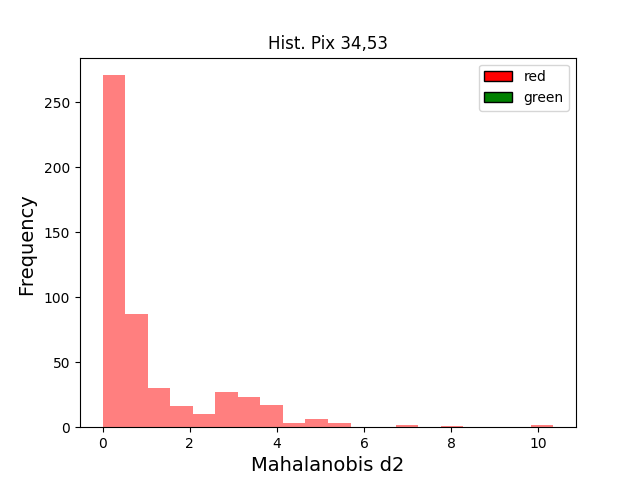

In [35]:
fig,ax = plt.subplots(1)
ax.hist(d2[0:501],bins = 20, color="red", alpha=0.5)#,range=[0.3,0.4])
ax.set_title('Hist. Pix '+str(i)+','+str(j))
ax.set_xlabel('Mahalanobis d2', fontsize=14)
ax.set_ylabel('Frequency ', fontsize=14)
#ax.set_yscale('log')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in col_normed]
ax.legend(handles, col_normed)
fig.canvas.draw()

The squared Mahalanobis distance follows a Chi-Square Distribution. How can we use this?

Have you followed how d2 behaves when no pedestrian was involved? What changed when the person crossed the pixel?
How can we make the decision if a pixel is being considered background in its current state or in other word. When can we verify or falsify our Hypothesis $H_0$ : The pixel is background.

# Part 3: Change Detection via a robust background model

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10, 4))
i_frame = 0
cap = cv2.VideoCapture(file)

is_cb = False
success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    if i_frame > len(d2_container):
        break
   
    #frame = frame[x1:x2,y1:y2]    
    ax[0].set_title("Orig. video")
    ax[0].imshow(frame)
    # display original frame 
    ax[1].set_title('Change Detection via Mahal. d2')
    ax[1].set_xlabel('Dark values indicate background',fontsize=14)    
    
    ax_handle = ax[1].imshow(d2_container[i_frame],cmap="gray",vmin=0, vmax=10)

    if not is_cb:
        # to do: cb is fixed to first frame, update colorbar
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        plt.colorbar(ax_handle,cax=cax)
        is_cb = True
        # directives for plotting and layout
    plt.tight_layout()
    fig.canvas.draw()
    #time.sleep(0.0001)
    # cleanup directives
    ax[0].clear()
    ax[1].clear()
    i_frame = i_frame+1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

<IPython.core.display.Javascript object>

Follow the calculation of the mean of the background estimates, the co-variance matrix and the mahalobis distance. 
Do these have to be calculated at every iteration? If no, when would you fix them?